In [75]:
import os
os.getcwd()

path_to_file = "C:\\Users\\david\\OneDrive\\Documents\\ml_projects\\afm-morphology-transfer-learning\\datasets\\afm_patches_256.h5"


In [76]:
import h5py

h5_path = path_to_file
with h5py.File(h5_path, "r") as f:
    def walk(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"{name}: shape={obj.shape}, dtype={obj.dtype}")
    f.visititems(walk)


patches/aux_type: shape=(202,), dtype=object
patches/base_id: shape=(202,), dtype=object
patches/norm: shape=(202, 2, 256, 256), dtype=float32
patches/proc: shape=(202, 2, 256, 256), dtype=float32
patches/raw: shape=(202, 2, 256, 256), dtype=float32
patches/source_aux_file: shape=(202,), dtype=object
patches/source_topo_file: shape=(202,), dtype=object
patches/top_left_yx: shape=(202, 2), dtype=int32
scans/meta_jsonl: shape=(43,), dtype=object


In [73]:
import h5py, numpy as np

h5 = path_to_file
with h5py.File(h5, "r") as f:
    print("Has norm:", "patches/norm" in f)
    print("proc shape:", f["patches/proc"].shape)
    print("norm shape:", f["patches/norm"].shape if "patches/norm" in f else None)
    print("attrs channel_norm_mean:", f.attrs.get("channel_norm_mean"))
    print("attrs channel_norm_std:", f.attrs.get("channel_norm_std"))
    print("attrs channel_norm_dataset_normalized:", f.attrs.get("channel_norm_dataset_normalized"))


Has norm: True
proc shape: (202, 2, 256, 256)
norm shape: (202, 2, 256, 256)
attrs channel_norm_mean: [2.989964485168457, 8.156561363825698e-13]
attrs channel_norm_std: [42.26519012451172, 7.2681366133919845e-12]
attrs channel_norm_dataset_normalized: patches/norm


In [74]:
import h5py, numpy as np

with h5py.File(h5, "r") as f:
    x = f["patches/norm"]
    # sample a chunk to keep it fast (first 2000 patches)
    n = min(2000, x.shape[0])
    arr = x[:n].astype(np.float64)

    for c in [0, 1]:
        m = arr[:, c].mean()
        s = arr[:, c].std()
        print("channel", c, "mean", m, "std", s)


channel 0 mean 6.0787482906188076e-09 std 0.9999999343828486
channel 1 mean -1.5737455025578264e-08 std 0.9999999322627732


In [58]:
import h5py, numpy as np

with h5py.File(h5, "r") as f:
    x = f["patches/proc"]
    n = min(2000, x.shape[0])
    arr = x[:n].astype(np.float64)

    mean = arr.mean(axis=(0,2,3))
    std  = arr.std(axis=(0,2,3))
    print("Direct proc mean:", mean)
    print("Direct proc std :", std)


Direct proc mean: [2.98996440e+00 8.15700675e-13]
Direct proc std : [4.22651875e+01 7.26830047e-12]


In [71]:
import h5py

with h5py.File(path_to_file, "r") as f:
    def visit(name, obj):
        if hasattr(obj, "shape"):
            print(f"{name:30s} {obj.shape}")
        else:
            print(name)
    f.visititems(visit)


patches
patches/aux_type               (202,)
patches/base_id                (202,)
patches/norm                   (202, 2, 256, 256)
patches/proc                   (202, 2, 256, 256)
patches/raw                    (202, 2, 256, 256)
patches/source_aux_file        (202,)
patches/source_topo_file       (202,)
patches/top_left_yx            (202, 2)
scans
scans/meta_jsonl               (43,)


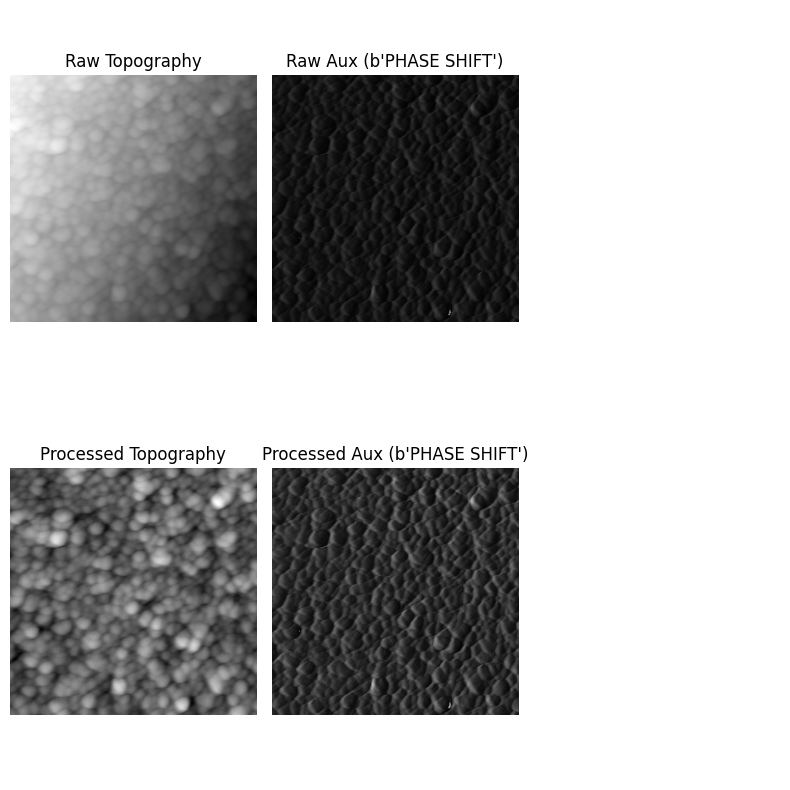

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

with h5py.File(path_to_file, "r") as f:
    raw = f["patches/raw"]
    proc = f["patches/norm"]
    aux_type = f["patches/aux_type"]

    i = np.random.randint(0, raw.shape[0])

    fig, ax = plt.subplots(2, 3, figsize=(8, 8))

    ax[0, 0].imshow(raw[i, 0], cmap="gray")
    ax[0, 0].set_title("Raw Topography")

    ax[0, 1].imshow(raw[i, 1], cmap="gray")
    ax[0, 1].set_title(f"Raw Aux ({aux_type[i]})")

    ax[1, 0].imshow(proc[i, 0], cmap="gray")
    ax[1, 0].set_title("Processed Topography")

    ax[1, 1].imshow(proc[i, 1], cmap="gray")
    ax[1, 1].set_title(f"Processed Aux ({aux_type[i]})")

    for a in ax.flat:
        a.axis("off")

    plt.tight_layout()
    plt.show()


## Check statistics

In [42]:
with h5py.File(path_to_file, "r") as f:
    proc = f["patches/norm"]

    topo = proc[:, 0]
    aux  = proc[:, 1]
    
    print("      mean ,  std,  min,  max,  range")
    print("Topo :", topo.mean(), topo.std(), topo.min(), topo.max(), topo.max() - topo.min())
    print("Aux  :", aux.mean(), aux.std(), aux.min(), aux.max(), aux.max() - aux.min())

      mean ,  std,  min,  max,  range
Topo : 4.131015e-09 1.0 -14.44317 11.53314 25.97631
Aux  : -1.8009796e-14 7.4607406e-06 -9.076727e-05 9.372761e-05 0.00018449489


##  Filter Aux type

In [26]:
with h5py.File(path_to_file, "r") as f:
    aux_type = f["patches/aux_type"][:].astype(str)

    phase_idx = np.where(aux_type == "PHASE")[0]
    friction_idx = np.where(aux_type == "FRICTION")[0]

    print("Phase patches:", len(phase_idx))
    print("Friction patches:", len(friction_idx))


Phase patches: 0
Friction patches: 27


## Reconstruct full scan

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

base_to_check = "samples070425_3"  # adjust

with h5py.File(path_to_file, "r") as f:
    raw = f["patches/raw"]
    base = f["patches/base_id"][:].astype(str)
    yx = f["patches/top_left_yx"][:]

    idxs = np.where(base == base_to_check)[0]
    if len(idxs) == 0:
        raise ValueError("No patches for this base_id")

    H = yx[idxs, 0].max() + 256
    W = yx[idxs, 1].max() + 256

    recon_topo = np.zeros((H, W), dtype=np.float32)
    recon_aux  = np.zeros((H, W), dtype=np.float32)

    for i in idxs:
        y, x = yx[i]
        recon_topo[y:y+256, x:x+256] = raw[i, 0]
        recon_aux[y:y+256, x:x+256] = raw[i, 1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(recon_topo, cmap="gray")
plt.title("Reconstructed Topography")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon_aux, cmap="gray")
plt.title("Reconstructed Aux")
plt.axis("off")
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

## MetaData

In [6]:
import json
import h5py

with h5py.File(path_to_file, "r") as f:
    meta = json.loads(f["scans/meta_jsonl"][0])
    print(meta)


{'base_id': 'perovskite_s101024_14_26', 'topo_file': 'data/data_gwy/perovskite_s101024_14_26_T.gwy', 'aux_file': 'data/data_gwy/perovskite_s101024_14_26_FRICTION.gwy', 'aux_type': 'FRICTION', 'topo_meta': {'source_file': 'data/data_gwy/perovskite_s101024_14_26_T.gwy', 'channel_title': 'Topography', 'xres': 400, 'yres': 400, 'xreal_m': 5e-06, 'yreal_m': 5e-06, 'dx_m_per_px': 1.2500000000000001e-08, 'dy_m_per_px': 1.2500000000000001e-08, 'available_titles': [['/0/data/title', 'Topography']]}, 'aux_meta': {'source_file': 'data/data_gwy/perovskite_s101024_14_26_FRICTION.gwy', 'channel_title': 'Topography', 'xres': 400, 'yres': 400, 'xreal_m': 5e-06, 'yreal_m': 5e-06, 'dx_m_per_px': 1.2500000000000001e-08, 'dy_m_per_px': 1.2500000000000001e-08, 'available_titles': [['/0/data/title', 'Topography']]}, 'crop_border_frac': 0.05, 'clip_sigma': 8.0, 'patch': 256, 'stride': 128, 'normalized_channels': [1]}


In [64]:
import h5py, numpy as np, json

with h5py.File(h5,"r") as f:
    # attrs
    mean_attr = np.array(json.loads(f.attrs["channel_norm_mean"]), dtype=np.float64)
    std_attr  = np.array(json.loads(f.attrs["channel_norm_std"]), dtype=np.float64)

    # direct proc
    x = f["patches/proc"][:].astype(np.float64)
    mean_proc = x.mean(axis=(0,2,3))
    std_proc  = x.std(axis=(0,2,3))

    # direct norm
    y = f["patches/norm"][:].astype(np.float64)
    mean_norm = y.mean(axis=(0,2,3))
    std_norm  = y.std(axis=(0,2,3))

print("ATTR mean/std:", mean_attr, std_attr)
print("PROC mean/std:", mean_proc, std_proc)
print("NORM mean/std:", mean_norm, std_norm)
print("std_proc / std_attr:", std_proc / std_attr)


ATTR mean/std: [2.98996449e+00 8.15656136e-13] [4.22651901e+01 9.99999994e-09]
PROC mean/std: [2.98996440e+00 8.15656124e-13] [4.22651875e+01 7.26813613e-12]
NORM mean/std: [ 6.07874829e-09 -1.13368975e-11] [9.99999934e-01 7.26813617e-04]
std_proc / std_attr: [9.99999937e-01 7.26813618e-04]
